In [1]:
import numpy as np
from bayesian_optimization.encoder import *
from code_construction.code_construction import *
from dataset import *
from botorch.models import SingleTaskGP
from torch import nn
from botorch.optim import optimize_acqf
from botorch.acquisition import AcquisitionFunction
from gpytorch.mlls import ExactMarginalLogLikelihood
import random
import numpy as np
import torch

def set_all_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_all_seeds(seed)



/home/cyyh/miniconda3/envs/QEC2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset

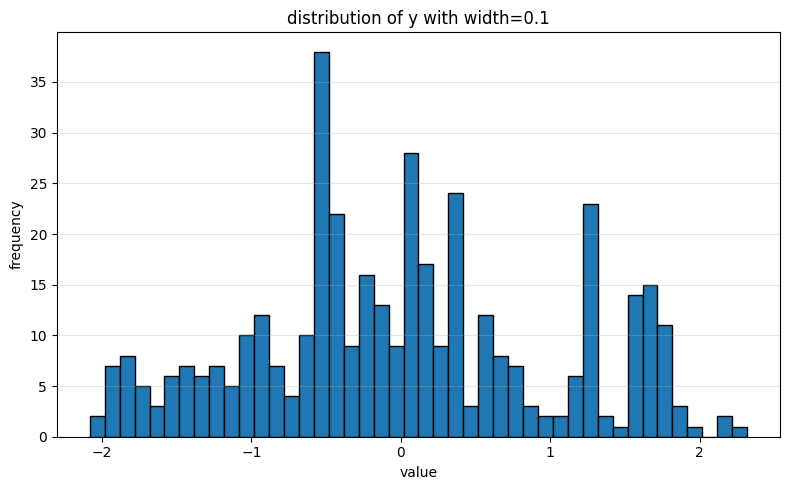

In [2]:
from sklearn.preprocessing import StandardScaler
# l = 6
# g = 3
# para_dict = {'l':l,'g':g}
# total_dataset = QEC_Dataset(l,g,load = True,number = 300,save = True)
total_dataset = MergeDatasets()
total_dataset.load(['./data/codes/bb_36_6_3_100_depolarizing.pkl',
                    './data/codes/bb_36_9_2_100_depolarizing.pkl',
                    './data/codes/hgp_36_2_2_3_100_depolarizing.pkl',
                    './data/codes/hgp_36_3_3_2_100_depolarizing.pkl'])
total_dataset.y = torch.tensor(total_dataset.y)



eps = 1e-20
total_dataset.y = torch.log(total_dataset.y + eps)


y_np = total_dataset.y.detach().cpu().numpy().reshape(-1, 1)
scaler = StandardScaler().fit(y_np)
total_dataset.y = scaler.transform(y_np)
total_dataset.y = torch.tensor(total_dataset.y)
# total_dataset.X = torch.tensor(total_dataset.X)


import random
from torch.utils.data import Subset
import pandas as pd
def plot_distribution(y, bin_width):
    bins = np.arange(np.min(y), np.max(y) + bin_width, bin_width)
    
    plt.figure(figsize=(8, 5))
    plt.hist(y, bins=bins, edgecolor='black')
    plt.xlabel('value')
    plt.ylabel('frequency')
    plt.title(f'distribution of y with width={bin_width}')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_distribution(total_dataset.y.detach().cpu().numpy(), bin_width=0.1)
# plot_distribution(total_dataset.y, bin_width=0.1)
def train_test_split(dataset, test_size=0.2, shuffle=True, random_state=None):
    """
    Split a Dataset into train and test subsets.

    Args:
        dataset (Dataset):   any PyTorch Dataset
        test_size (float):   fraction of the data to reserve for testing (0 < test_size < 1)
        shuffle (bool):      whether to shuffle indices before splitting
        random_state (int):  seed for reproducible shuffling

    Returns:
        train_dataset (Subset), test_dataset (Subset)
    """
    # Determine split sizes
    n = len(dataset)
    n_test = int(n * test_size)
    n_train = n - n_test

    # Create index list
    indices = list(range(n))
    if shuffle:
        rnd = random.Random(random_state)
        rnd.shuffle(indices)

    # Split
    train_idx = indices[:n_train]
    test_idx  = indices[n_train:]

    # Wrap in Subset
    train_dataset = QECSubset(dataset, train_idx)
    test_dataset  = QECSubset(dataset, test_idx)
    return train_dataset, test_dataset
def evaluate_gp_on_test(
    test_data,
    model,
    *,
    plot: bool = True,
    return_df: bool = False,
    use_std: bool = False
):

    X_test = torch.tensor(test_data.X, dtype=torch.float32)
    y_test = torch.tensor(test_data.y, dtype=torch.float32)


    model.eval()
    model.likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():

        posterior = model.posterior(X_test)
        mean = posterior.mean
        var = posterior.variance



    err = torch.sqrt(var) if use_std else var


    mse = torch.mean((mean - y_test) ** 2).item()
    ss_res = torch.sum((y_test - mean) ** 2).item()
    ss_tot = torch.sum((y_test - torch.mean(y_test)) ** 2).item()
    r2     = 1 - ss_res / ss_tot if ss_tot > 0 else float('nan')

    y_test = y_test.squeeze(-1)   
    mean = mean.squeeze(-1) 
    err = err.squeeze(-1) 
    idx = torch.argsort(y_test)
    y_sorted = y_test[idx].numpy()
    m_sorted = mean[idx].numpy()
    e_sorted = err[idx].numpy()

    
    if plot:
        plt.figure()
        plt.plot(y_sorted, label='True values')
        plt.plot(m_sorted, label='Predicted mean')
        plt.plot(m_sorted + e_sorted, label=f'Mean + {"STD" if use_std else "Var"}')
        plt.plot(m_sorted - e_sorted, label=f'Mean - {"STD" if use_std else "Var"}')
        plt.xlabel('Samples (sorted by true value)')
        plt.ylabel('Value')
        plt.title('True vs Predicted mean ± ' + ("STD" if use_std else "VAR"))
        plt.legend()
        plt.tight_layout()
        plt.show()


    df = pd.DataFrame({
        'True value': y_sorted,
        'Predicted mean': m_sorted,
        'Predicted ' + ('std' if use_std else 'var'): e_sorted
    })

    if return_df:
        return mse,r2, df
    return mse,r2


# model = get_model(l,g,torch.tensor(train_dataset.X,dtype=torch.float32),torch.tensor(train_dataset.y,dtype=torch.float32))

# Initialize the Encoding

Here we define the function of encoding. Encoding is a mapping that maps the binary vector representation of the CSS code to the chain-complex relation matrices representation. 

We pre-define the multi-view representations by using a list:

`view_infos = List[
    Dict{
        'name' (str),
        'partite_classes' List[str],
        'relations': List[str]
    }
]`
, for example:

`views_info = [
  {"name":"decode",
   "partite_classes":["SZ","DQ","SX"],
   "relations":["SZ_DQ","DQ_SZ","DQ_SX","SX_DQ"],   
  },
  {"name":"xlogic",
   "partite_classes":["DQ","SX","LX"],
   "relations":["DQ_SX","SX_DQ","LX_DQ","DQ_LX"],
   },
  {"name":"zlogic",
   "partite_classes":["SZ","DQ","LZ"],
   "relations":["SZ_DQ","DQ_SZ","LZ_DQ","DQ_LZ"],
   },
]`.

See the definition in `bayesian_optimization.encoder.RelationEncoder`.

The following code shows an example (3-view representation).

In [5]:
views_info = [
  {"name":"decode",
   "partite_classes":["SZ","DQ","SX"],
   "relations":["SZ_DQ","DQ_SZ","DQ_SX","SX_DQ"],   
   },
  {"name":"xlogic",
   "partite_classes":["DQ","SX","LX"],
   "relations":["DQ_SX","SX_DQ","LX_DQ","DQ_LX"],
   },
  {"name":"zlogic",
   "partite_classes":["SZ","DQ","LZ"],
   "relations":["SZ_DQ","DQ_SZ","LZ_DQ","DQ_LZ"],
   },
]
# views_info = [
#   {"name":"decode",
#    "partite_classes":["SZ","DQ","SX"],
#    "relations":["SZ_DQ","DQ_SZ","DQ_SX","SX_DQ"],   
#    },
# ]
# views_info = [
#   {"name":"decode",
#    "partite_classes":["SZ","DQ","SX"],
#    "relations":["SZ_DQ","DQ_SZ","DQ_SX","SX_DQ"],   
#    },
#   {"name":"xlogic",
#    "partite_classes":["DQ","SX","LX"],
#    "relations":["DQ_SX","SX_DQ","LX_DQ","DQ_LX"],
#    },
#   {"name":"zlogic",
#    "partite_classes":["SZ","DQ","LZ"],
#    "relations":["SZ_DQ","DQ_SZ","LZ_DQ","DQ_LZ"],
#    },
#    {"name":"xzlogic",
#    "partite_classes":["LX","DQ","LZ"],
#    "relations":["LX_DQ","DQ_LX","LZ_DQ","DQ_LZ"],
#    },
# ]
# views_info = [
#   {"name":"5-partite",
#    "partite_classes":["SZ","DQ","SX","LX","LZ"],
#    "relations":["SZ_DQ","DQ_SZ","DQ_SX","SX_DQ","LX_DQ","DQ_LX","LZ_DQ","DQ_LZ"],   
#    },
# ]
# views_info = [
#   {"name":"decode",
#    "partite_classes":["SZ","DQ","SX"],
#    "relations":["SZ_DQ","DQ_SZ","DQ_SX","SX_DQ"],   
#    },
#   {"name":"xlogic",
#    "partite_classes":["DQ","SX","LZ"],
#    "relations":["DQ_SX","SX_DQ","LZ_DQ","DQ_LZ"],
#    },
#   {"name":"zlogic",
#    "partite_classes":["SZ","DQ","LX"],
#    "relations":["SZ_DQ","DQ_SZ","LX_DQ","DQ_LX"],
#    },
# ]
# views_info = [
#   # Z-error chain (SZ -> DQ) 
#   {"name":"decode_z", "partite_classes":["SZ","DQ"],
#    "relations":["SZ_DQ"], },

#   # X-error chain (DQ -> SX) 
#   {"name":"decode_x", "partite_classes":["DQ","SX"],
#    "relations":["DQ_SX"], },

#   {"name":"xlogic", "partite_classes":["DQ","SX","LX"],
#    "relations":["DQ_SX","SX_DQ","LX_DQ","DQ_LX"], },

#   {"name":"zlogic", "partite_classes":["SZ","DQ","LZ"],
#    "relations":["SZ_DQ","DQ_SZ","LZ_DQ","DQ_LZ"], },
# ]



# An Example of the Encoding
class E():
    def __init__(self,views_info ):
        self.encoder = CSSEncoder(views_info,mode ='relations')

    def encode_single(self,x):
        return self.encoder.encode(x)
    def encode(self,x):
        # x: B views
        return [self.encode_single(i) for i in x]

e = E(views_info)
e.encode_single(total_dataset.X[0])

{'decode': {'sizes': {'SZ': 18, 'DQ': 36, 'SX': 18},
  'adj': {'SZ_DQ': tensor(indices=tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,
                            3,  3,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,
                            7,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10,
                           10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13,
                           14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17,
                           17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23,
                           24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30,
                           31, 31, 32, 32, 33, 33, 34, 34, 35, 35],
                          [ 0,  3,  9, 15,  1,  4, 10, 16,  2,  5, 11, 17,  0,  3,
                            6, 12,  1,  4,  7, 13,  2,  5,  8, 14,  3,  6,  9, 15,
                            4,  7, 10, 16,  5,  8, 11, 17,  0,  6,  9, 12,  1,  7,
                           10, 13

In [6]:
train_dataset, test_dataset = train_test_split(total_dataset,
                                         test_size=0.2,
                                         shuffle=True,
                                         random_state=seed)
from torch import nn, optim

def train_gpytorch_model(model, train_x, train_y, training_iter=50, lr=0.002):
    model.train()
    model.likelihood.train()

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    history = []
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)   # MultivariateNormal over latent f
        loss = -mll(output, train_y.squeeze(-1))
        loss.backward()
        optimizer.step()
        history.append(loss.item())
    plt.plot(history)
    return loss.item()
def train_gpytorch_model_seperate(model, train_x, train_y, training_iter=50, lr=0.002):
    model.train()
    model.likelihood.train()
    try:
        nn_parameters = list(model.mean_module.parameters()) + list(model.embed.parameters())
        kernel_parameters = list(model.covar_module.parameters())
        likelihood_parameters = list(model.likelihood.parameters())


        optimizer = torch.optim.AdamW([
            {'params': nn_parameters, 'lr': 0.001}, 
            {'params': kernel_parameters, 'lr': 0.0001}, 
            {'params': likelihood_parameters, 'lr': 0.02}  
        ])
    except:
        nn_parameters =  list(model.embed.parameters())
        kernel_parameters = list(model.covar_module.parameters())
        likelihood_parameters = list(model.likelihood.parameters())


        optimizer = torch.optim.AdamW([
            {'params': nn_parameters, 'lr': 0.005}, 
            {'params': kernel_parameters, 'lr': 0.001}, 
            {'params': likelihood_parameters, 'lr': 0.02} ])
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    history = []
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)   # MultivariateNormal over latent f
        loss = -mll(output, train_y.squeeze(-1))
        loss.backward()
        optimizer.step()
        history.append(loss.item())
    plt.plot(history)
    return loss.item()

# Results

### Simulated decoder & two code with their counterpart logic
views_info = [
  {"name":"decode",
   "partite_classes":["SZ","DQ","SX"],
   "relations":["SZ_DQ","DQ_SZ","DQ_SX","SX_DQ"],   
   "weight_mode":"count", "log1p":True},
  {"name":"xlogic",
   "partite_classes":["DQ","SX","LX"],
   "relations":["DQ_SX","SX_DQ","LX_DQ","DQ_LX"],
   "weight_mode":"count", "log1p":True},
  {"name":"zlogic",
   "partite_classes":["SZ","DQ","LZ"],
   "relations":["SZ_DQ","DQ_SZ","LZ_DQ","DQ_LZ"],
   "weight_mode":"count", "log1p":True},
]

Test MSE: 0.049354
R² Score: 0.9541
Test MSE: 0.365196
R² Score: 0.6062


GP:'avg_per_point_pdf': 0.42473340034484863

### Simulated decoder & two code with their counterpart logic & 2Logic

GP:Test  MSE: 0.555541  |  Test  R2: 0.400956


### Two seperated code(check and its orthogonal space) & simulated decoder
views_info = [
  {"name":"decode",
   "partite_classes":["SZ","DQ","SX"],
   "relations":["SZ_DQ","DQ_SZ","DQ_SX","SX_DQ"],   
   "weight_mode":"count", "log1p":True},
  {"name":"xlogic",
   "partite_classes":["DQ","SX","LZ"],
   "relations":["DQ_SX","SX_DQ","LZ_DQ","DQ_LZ"],
   "weight_mode":"count", "log1p":True},
  {"name":"zlogic",
   "partite_classes":["SZ","DQ","LX"],
   "relations":["SZ_DQ","DQ_SZ","LX_DQ","DQ_LX"],
   "weight_mode":"count", "log1p":True},
]
Test MSE: 0.047245
R² Score: 0.9561
Test MSE: 0.531903
R² Score: 0.4264





### One big graph

views_info = [
  {"name":"decode",
   "partite_classes":["SZ","DQ","SX","LX","LZ"],
   "relations":["SZ_DQ","DQ_SZ","DQ_SX","SX_DQ","LX_DQ","DQ_LX","LZ_DQ","DQ_LZ"],   
   "weight_mode":"count", "log1p":True},
]
Test MSE: 0.087965
R² Score: 0.9182
Test MSE: 0.493410
R² Score: 0.4680

GP: Test  MSE: 0.525766  |  Test  R2: 0.433063

views_info = [
  {"name":"decode",
   "partite_classes":["SZ","DQ","SX"],
   "relations":["SZ_DQ","DQ_SZ","DQ_SX","SX_DQ"],   
   "weight_mode":"count", "log1p":True},
  {"name":"xlogic",
   "partite_classes":["DQ","SX","AX"],
   "relations":["DQ_SX","SX_DQ","AX_DQ","DQ_AX"],
   "weight_mode":"count", "log1p":True},
  {"name":"zlogic",
   "partite_classes":["SZ","DQ","AZ"],
   "relations":["SZ_DQ","DQ_SZ","AZ_DQ","DQ_AZ"],
   "weight_mode":"count", "log1p":True},
]


### split the decoder with one way only message passing & two code with their counterpart logic
views_info = [

  {"name":"decode_z", "partite_classes":["SZ","DQ"],
   "relations":["SZ_DQ"], "weight_mode":"count", "log1p":True},


  {"name":"decode_x", "partite_classes":["DQ","SX"],
   "relations":["DQ_SX"], "weight_mode":"count", "log1p":True},

  {"name":"xlogic", "partite_classes":["DQ","SX","LX"],
   "relations":["DQ_SX","SX_DQ","LX_DQ","DQ_LX"], "weight_mode":"count", "log1p":True},

  {"name":"zlogic", "partite_classes":["SZ","DQ","LZ"],
   "relations":["SZ_DQ","DQ_SZ","LZ_DQ","DQ_LZ"], "weight_mode":"count", "log1p":True},
]
Test MSE: 0.122583
R² Score: 0.8860
Test MSE: 0.637801
R² Score: 0.3123

# Test our embedding on nn-regressor

Epoch   1 | Loss: 0.318859
Epoch   2 | Loss: 0.236694
Epoch   3 | Loss: 0.217672
Epoch   4 | Loss: 0.210474
Epoch   5 | Loss: 0.199423
Epoch   6 | Loss: 0.214220
Epoch   7 | Loss: 0.199688
Epoch   8 | Loss: 0.203249
Epoch   9 | Loss: 0.187467
Epoch  10 | Loss: 0.190376
Epoch  11 | Loss: 0.194188
Epoch  12 | Loss: 0.183740
Epoch  13 | Loss: 0.186241
Epoch  14 | Loss: 0.184350
Epoch  15 | Loss: 0.174657
Epoch  16 | Loss: 0.183481
Epoch  17 | Loss: 0.176370
Epoch  18 | Loss: 0.172502
Epoch  19 | Loss: 0.160232
Epoch  20 | Loss: 0.163823
Epoch  21 | Loss: 0.154833
Epoch  22 | Loss: 0.162528
Epoch  23 | Loss: 0.149254
Epoch  24 | Loss: 0.143769
Epoch  25 | Loss: 0.172772


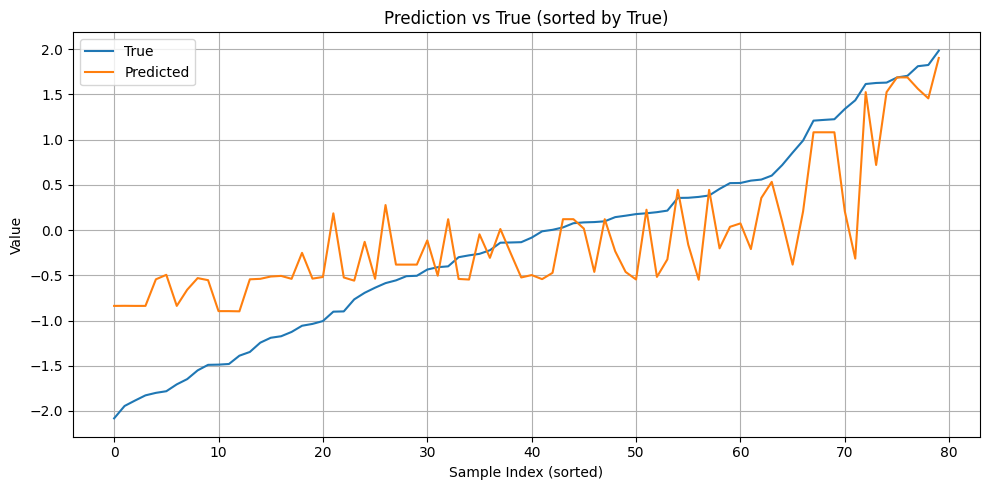

Test MSE: 0.411219
R² Score: 0.6324
Epoch  26 | Loss: 0.154059
Epoch  27 | Loss: 0.143227
Epoch  28 | Loss: 0.149588
Epoch  29 | Loss: 0.142508
Epoch  30 | Loss: 0.129562
Epoch  31 | Loss: 0.133575
Epoch  32 | Loss: 0.134543
Epoch  33 | Loss: 0.130371
Epoch  34 | Loss: 0.120946
Epoch  35 | Loss: 0.122995
Epoch  36 | Loss: 0.123962
Epoch  37 | Loss: 0.126102
Epoch  38 | Loss: 0.127146
Epoch  39 | Loss: 0.121188
Epoch  40 | Loss: 0.123526
Epoch  41 | Loss: 0.116458
Epoch  42 | Loss: 0.119750
Epoch  43 | Loss: 0.122837
Epoch  44 | Loss: 0.119757
Epoch  45 | Loss: 0.113774
Epoch  46 | Loss: 0.114809
Epoch  47 | Loss: 0.109918
Epoch  48 | Loss: 0.105860
Epoch  49 | Loss: 0.106406
Epoch  50 | Loss: 0.105855


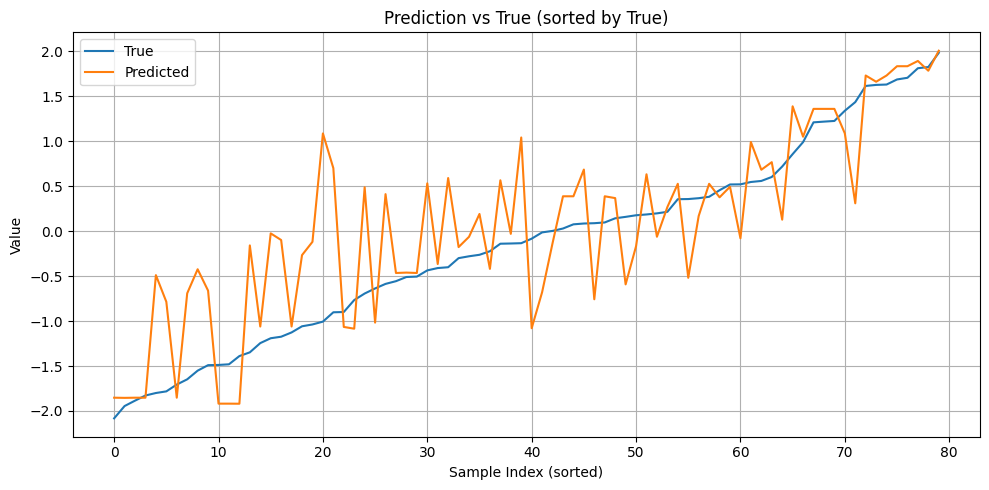

Test MSE: 0.411573
R² Score: 0.6321
Epoch  51 | Loss: 0.106542
Epoch  52 | Loss: 0.103152
Epoch  53 | Loss: 0.103517
Epoch  54 | Loss: 0.092629
Epoch  55 | Loss: 0.124167
Epoch  56 | Loss: 0.108883
Epoch  57 | Loss: 0.107365
Epoch  58 | Loss: 0.104630
Epoch  59 | Loss: 0.090972
Epoch  60 | Loss: 0.092814
Epoch  61 | Loss: 0.085010
Epoch  62 | Loss: 0.077792
Epoch  63 | Loss: 0.078269
Epoch  64 | Loss: 0.083287
Epoch  65 | Loss: 0.071687
Epoch  66 | Loss: 0.082848
Epoch  67 | Loss: 0.074119
Epoch  68 | Loss: 0.098934
Epoch  69 | Loss: 0.062886
Epoch  70 | Loss: 0.061841
Epoch  71 | Loss: 0.065269
Epoch  72 | Loss: 0.060058
Epoch  73 | Loss: 0.058145
Epoch  74 | Loss: 0.058967
Epoch  75 | Loss: 0.075962


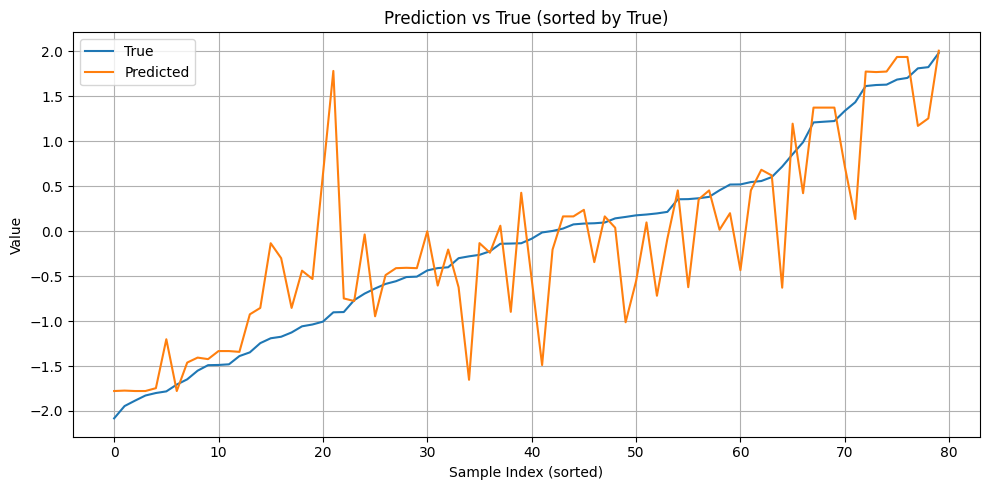

Test MSE: 0.378216
R² Score: 0.6619
Epoch  76 | Loss: 0.064937
Epoch  77 | Loss: 0.050079
Epoch  78 | Loss: 0.055219
Epoch  79 | Loss: 0.053107
Epoch  80 | Loss: 0.065674
Epoch  81 | Loss: 0.074585
Epoch  82 | Loss: 0.071789
Epoch  83 | Loss: 0.063313
Epoch  84 | Loss: 0.050698
Epoch  85 | Loss: 0.058837
Epoch  86 | Loss: 0.049046
Epoch  87 | Loss: 0.044147
Epoch  88 | Loss: 0.055033
Epoch  89 | Loss: 0.046234
Epoch  90 | Loss: 0.036136
Epoch  91 | Loss: 0.035275
Epoch  92 | Loss: 0.047785
Epoch  93 | Loss: 0.040791
Epoch  94 | Loss: 0.047713
Epoch  95 | Loss: 0.042139
Epoch  96 | Loss: 0.036102
Epoch  97 | Loss: 0.034951
Epoch  98 | Loss: 0.038887
Epoch  99 | Loss: 0.035606
Epoch 100 | Loss: 0.034245


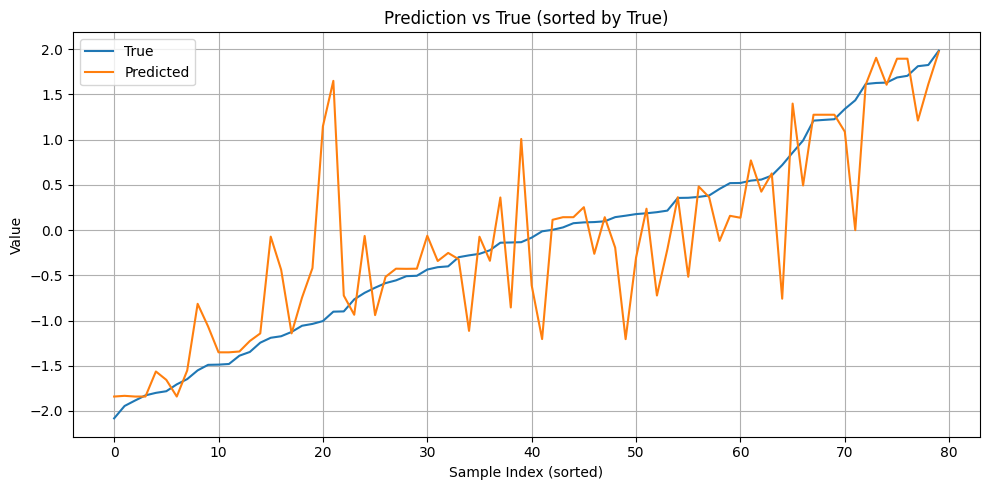

Test MSE: 0.374343
R² Score: 0.6654
Epoch 101 | Loss: 0.032393
Epoch 102 | Loss: 0.029607
Epoch 103 | Loss: 0.028110
Epoch 104 | Loss: 0.030553
Epoch 105 | Loss: 0.029351
Epoch 106 | Loss: 0.024944
Epoch 107 | Loss: 0.024700
Epoch 108 | Loss: 0.030539
Epoch 109 | Loss: 0.031320
Epoch 110 | Loss: 0.031327
Epoch 111 | Loss: 0.030809
Epoch 112 | Loss: 0.029617
Epoch 113 | Loss: 0.032479
Epoch 114 | Loss: 0.030788
Epoch 115 | Loss: 0.066005
Epoch 116 | Loss: 0.061317
Epoch 117 | Loss: 0.033944
Epoch 118 | Loss: 0.027432
Epoch 119 | Loss: 0.036940
Epoch 120 | Loss: 0.055142
Epoch 121 | Loss: 0.035384
Epoch 122 | Loss: 0.033386
Epoch 123 | Loss: 0.032751
Epoch 124 | Loss: 0.028801
Epoch 125 | Loss: 0.022487


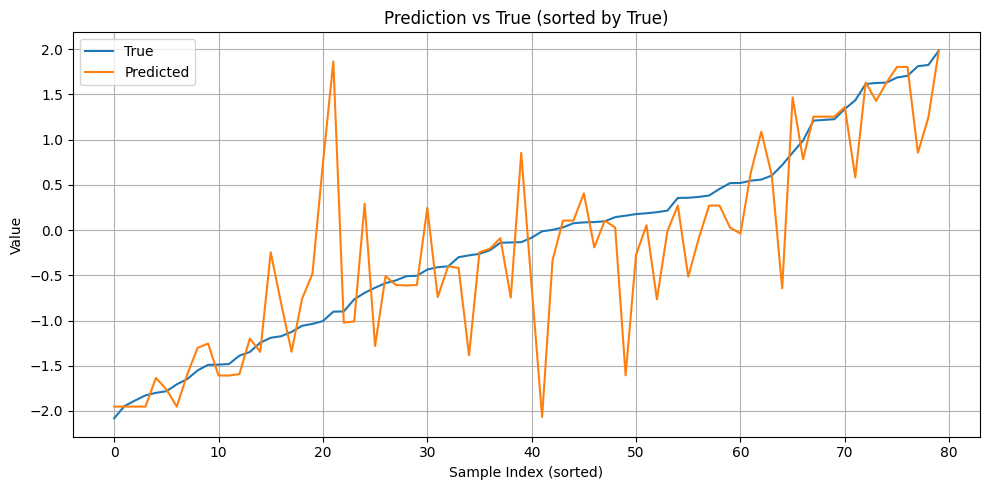

Test MSE: 0.406312
R² Score: 0.6368
Epoch 126 | Loss: 0.025907
Epoch 127 | Loss: 0.027972
Epoch 128 | Loss: 0.025494
Epoch 129 | Loss: 0.019651
Epoch 130 | Loss: 0.027020
Epoch 131 | Loss: 0.037656
Epoch 132 | Loss: 0.028049
Epoch 133 | Loss: 0.030038
Epoch 134 | Loss: 0.029521
Epoch 135 | Loss: 0.030721
Epoch 136 | Loss: 0.024325


KeyboardInterrupt: 

In [10]:
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from bayesian_optimization.chaincomplexembedding import *
@torch.no_grad()
def show_results(model, data_loader, encoder: E, device: torch.device):
    model.eval()

    mse_sum = 0.0
    n_total = 0
    y_all = []
    pred_all = []

    for x_batch, y_batch in data_loader:
        # Encode to list-of-views; do NOT move to device here
        sample_views_list = encoder.encode(x_batch)
        y_batch = y_batch.to(device).float().view(-1, 1)

        pred = model(sample_views_list)  # (B,1) on device
        mse_sum += torch.sum((pred - y_batch) ** 2).item()
        n_total += y_batch.size(0)

        y_all.append(y_batch.cpu())
        pred_all.append(pred.cpu())

    y_all = torch.cat(y_all, dim=0).view(-1)
    pred_all = torch.cat(pred_all, dim=0).view(-1)

    # Sorted visualization
    paired = list(zip(y_all.tolist(), pred_all.tolist()))
    paired.sort(key=lambda t: t[0])
    y_sorted = [t[0] for t in paired]
    p_sorted = [t[1] for t in paired]

    plt.figure(figsize=(10, 5))
    plt.plot(y_sorted, label='True')
    plt.plot(p_sorted, label='Predicted')
    plt.title("Prediction vs True (sorted by True)")
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Metrics
    mse = mse_sum / n_total
    var_y = torch.var(y_all, unbiased=False).item()
    nMSE = mse / (var_y + 1e-12)
    R2 = 1.0 - nMSE

    print(f"Test MSE: {mse:.6f}")
    print(f"R² Score: {R2:.4f}")
# 1) Build the embedder (uses the same views_info you defined)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedder = ChainComplexEmbedder(
    views_info=views_info,
    d_model=128,          # you can tune
    num_layers=4,         # you can tune
    view_aggr="sum",
    num_bases=4,          # basis decomposition for relation weights
    norm="sym",
    residual=True,
    self_loop=False,
    dropout=0.1,
).to(device)

# 2) Add a small regression head on top of the embedding (B, d_model) -> (B, 1)
class QECRegressor(nn.Module):
    def __init__(self, embedder: nn.Module, d_model: int = 128):
        super().__init__()
        self.embedder = embedder
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1),
        )
    def forward(self, sample_views_list):
        z = self.embedder(sample_views_list)  # (B, d_model)
        return self.head(z)                   # (B, 1)

model = QECRegressor(embedder, d_model=128).to(device)

# 3) Loss and optimizer
class LogCoshLoss(nn.Module):
    def forward(self, y_pred, y_true):
        # y_pred, y_true: (B,) or (B,1)
        diff = y_pred - y_true
        # log(cosh(x)) = x + softplus(-2x) - ln(2)
        return torch.mean(diff + torch.nn.functional.softplus(-2.0 * diff) - math.log(2.0))

criterion = LogCoshLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# 4) Data
def custom_collate(batch):
    xs, ys = zip(*batch)
    return list(xs), torch.tensor(ys, dtype=torch.float32)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,collate_fn=custom_collate)
test_loader  = DataLoader(test_dataset,  batch_size=32,collate_fn=custom_collate)

# Your encoder wrapper (already defined in your message)
# para_dict, codeconstructor are already defined as you said.
encoder = E(views_info)

# 5) Training loop
model.train()
history = []
epochs = 200

for epoch in range(epochs):
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        # x_batch: whatever your dataset yields (e.g., adjacency tensors or parameters)
        #          encoder.encode(x_batch) -> List[views dict] of length B
        sample_views_list = encoder.encode(x_batch)           # DO NOT .to(device); it's a list of dicts
        y_batch = y_batch.to(device).float().view(-1, 1)      # (B,1)

        optimizer.zero_grad()
        pred = model(sample_views_list)                       # (B,1)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg = total_loss / len(train_loader)
    history.append(avg)
    if epoch%25 == 0 and epoch>=1:
        show_results(model, test_loader,  encoder, device)
    print(f"Epoch {epoch+1:>3d} | Loss: {avg:.6f}")

plt.figure()
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Train Loss (log-cosh)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6) Evaluation helper (MSE / R^2 + a visual check)
@torch.no_grad()
def show_results(model, data_loader, encoder: E, device: torch.device):
    model.eval()

    mse_sum = 0.0
    n_total = 0
    y_all = []
    pred_all = []

    for x_batch, y_batch in data_loader:
        # Encode to list-of-views; do NOT move to device here
        sample_views_list = encoder.encode(x_batch)
        y_batch = y_batch.to(device).float().view(-1, 1)

        pred = model(sample_views_list)  # (B,1) on device
        mse_sum += torch.sum((pred - y_batch) ** 2).item()
        n_total += y_batch.size(0)

        y_all.append(y_batch.cpu())
        pred_all.append(pred.cpu())

    y_all = torch.cat(y_all, dim=0).view(-1)
    pred_all = torch.cat(pred_all, dim=0).view(-1)

    # Sorted visualization
    paired = list(zip(y_all.tolist(), pred_all.tolist()))
    paired.sort(key=lambda t: t[0])
    y_sorted = [t[0] for t in paired]
    p_sorted = [t[1] for t in paired]

    plt.figure(figsize=(10, 5))
    plt.plot(y_sorted, label='True')
    plt.plot(p_sorted, label='Predicted')
    plt.title("Prediction vs True (sorted by True)")
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Metrics
    mse = mse_sum / n_total
    var_y = torch.var(y_all, unbiased=False).item()
    nMSE = mse / (var_y + 1e-12)
    R2 = 1.0 - nMSE

    print(f"Test MSE: {mse:.6f}")
    print(f"R² Score: {R2:.4f}")

# 7) Run evaluation on train/test
show_results(model, train_loader, encoder, device)
show_results(model, test_loader,  encoder, device)


# Test our embedding in Gaussian Process

In [ ]:
# ======= GP + NN Embedder for QEC =======
import math
import numpy as np
import torch
import torch.nn as nn
import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, MaternKernel, SpectralMixtureKernel, ScaleKernel
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class GaussianProcess_QEC(gpytorch.models.ExactGP):
    """
    ExactGP that:
      X (continuous/int design) --(encoder.encode)-> list[views]
      --> embedder(list) -> z in R^d
      --> GP mean(z), cov(z)
    """

    def __init__(self, train_x, train_y,
                 *,
                 likelihood: gpytorch.likelihoods.GaussianLikelihood,
                 kernel: gpytorch.kernels.Kernel,
                 encoder,             # callable: encode(X_batch) -> list of views
                 embedding: nn.Module,  # ChainComplexEmbedder
                 mean: str = 'constant',
                 mean_input: int = 64):
        # train_y must be 1D for ExactGP; we'll squeeze in caller
        super().__init__(train_x, train_y.squeeze(-1) if train_y.dim() == 2 else train_y, likelihood)
        self.encoder = encoder            # Python callable (non-differentiable wrt X)
        self.embed = embedding            # nn.Module on device
        self.embed.to(device)

        d_model = next(self.embed.parameters()).shape[-1] if hasattr(self.embed, 'parameters') else 128
        d_model = getattr(self.embed, 'd_model', d_model)

        # Mean module
        if mean == 'zero':
            self.mean_module = gpytorch.means.ZeroMean()
        elif mean == 'constant':
            self.mean_module = gpytorch.means.ConstantMean()
        elif mean == 'linear':
            self.mean_module = gpytorch.means.LinearMean(input_size=d_model)
        elif mean == 'nn':
            # Small MLP mean head on top of z
            self.nn_mean = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, mean_input),
                nn.GELU(),
                nn.Linear(mean_input, 1),
            ).to(device)
            # wrap to a Mean that calls nn_mean 
            class _NNMean(gpytorch.means.Mean):
                def __init__(self, head): 
                    super().__init__(); self.head = head
                def forward(self, x):      
                    return self.head(x).squeeze(-1)
            self.mean_module = _NNMean(self.nn_mean)
        else:
            self.mean_module = gpytorch.means.ConstantMean()


        self.covar_module = kernel


        self._cache_last_inputs = None
        self._cache_last_z = None

    def _x_to_z(self, X: torch.Tensor) -> torch.Tensor:
        """
        Convert a batch of design vectors X (B, D) to embedding z (B, d_model).
        """
        # Move to CPU numpy for code constructor if needed
        X_np = X.detach().cpu().numpy() if isinstance(X, torch.Tensor) else np.asarray(X)
        sample_views_list = self.encoder(X_np)            # list of views (len=B)
        # embedder.forward(list) packs internally and returns (B, d_model)
        z = self.embed(sample_views_list)                 # (B, d_model) on device
        return z

    def forward(self, X: torch.Tensor) -> MultivariateNormal:
        """
        Return latent f(X) distribution (MVN). GPyTorch's likelihood wraps this to p(y|X).
        """
        X = X.to(device)
        z = self._x_to_z(X)                               
        # cache
        self._cache_last_inputs = X
        self._cache_last_z = z

        mean_x = self.mean_module(z)                     
        covar_x = self.covar_module(z)                    
        return MultivariateNormal(mean_x, covar_x)


    def posterior(self, X: torch.Tensor):
        self.eval(); self.likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            # predictive distribution of y
            return self.likelihood(self(X.to(device)))


# --------- Modeling ---------
def get_model_( X, y, kernel_type='ard_rbf', mean_type='linear', mean_input=64):



    encoder = E(views_info)
    embed_dim = 128
    # NN embedder
    embedding = ChainComplexEmbedder(
        views_info=views_info,
        d_model=embed_dim ,
        num_layers=4,
        view_aggr="sum",
        num_bases=4,
        norm="sym",
        residual=True,
        self_loop=False,
        dropout=0.1,
    ).to(device)



    # kernel
    if kernel_type == 'ard_rbf':
        base = RBFKernel(ard_num_dims=embed_dim)
        kernel = ScaleKernel(base)
    elif kernel_type == 'matern':
        base = MaternKernel(nu=1.5, ard_num_dims=embed_dim)
        kernel = ScaleKernel(base)
    elif kernel_type == 'spectral_mixture':
        kernel = SpectralMixtureKernel(num_mixtures=4, ard_num_dims=embed_dim)
    elif kernel_type == 'rbf_plus_periodic':
        from gpytorch.kernels import PeriodicKernel
        rbf = ScaleKernel(RBFKernel(ard_num_dims=embed_dim))
        periodic = ScaleKernel(PeriodicKernel(ard_num_dims=embed_dim))
        kernel = rbf + periodic
    else:
        kernel = ScaleKernel(RBFKernel())

    # likelihood
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    # train_x/y to device, y -> 1D for ExactGP
    train_x = X.to(device).float()
    train_y = y.to(device).float().view(-1)

    gp = GaussianProcess_QEC(
        train_x, train_y,
        likelihood=likelihood,
        kernel=kernel,
        encoder=encoder.encode,
        embedding=embedding,
        mean=mean_type,
        mean_input=mean_input,
    ).to(device)

    return gp


# --------- Train ---------
def train_gpytorch_model_separate(model, train_x, train_y, training_iter=100):
    model.train(); model.likelihood.train()
    # parameter groups
    params_embed = list(model.embed.parameters())
    params_kernel = list(model.covar_module.parameters()) if hasattr(model, "covar_module") else []
    params_like = list(model.likelihood.parameters())
    params_mean = list(model.mean_module.parameters()) if hasattr(model, "mean_module") else []


    optimizer = torch.optim.AdamW([
        {'params': params_embed,  'lr': 4e-4},
        {'params': params_mean,   'lr': 1e-3},
        {'params': params_kernel, 'lr': 1e-3},
        {'params': params_like,   'lr': 2e-2},
    ])

    mll = ExactMarginalLogLikelihood(model.likelihood, model)


    train_x = train_x.to(device).float()
    train_y = train_y.to(device).float().view(-1)  # 1D

    history = []
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)            # MVN over latent f
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        history.append(loss.item())

        if (i+1) % max(1, training_iter//10) == 0:
            print(f"[{i+1:>4d}/{training_iter}] nll={loss.item():.4f}, "
                  f"noise={model.likelihood.noise.item():.3e}")

    plt.figure()
    plt.plot(history)
    plt.xlabel("iter"); plt.ylabel("Neg. MLL")
    plt.title("GP training curve")
    plt.grid(True); plt.tight_layout()
    plt.show()
    return float(history[-1])


# --------- Evaluate ---------
@torch.no_grad()
def evaluate_gp_on_test(
    test_data,
    model,
    *,
    plot=True,
    return_df=False,
    use_std=True,
    plot_mll_hist=True,
    bins=30
):
    import torch
    import gpytorch
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    device = next(model.parameters()).device
    model.eval(); model.likelihood.eval()

    X_test = torch.tensor(test_data.X, dtype=torch.float32, device=device)
    y_test = torch.tensor(test_data.y, dtype=torch.float32, device=device).view(-1)

    with gpytorch.settings.fast_pred_var():
        # predictive distribution of y (test predictive)
        pred = model.likelihood(model(X_test))   # MultivariateNormal over y|X
        mean = pred.mean                         
        var  = pred.variance                     

    # error band for plotting
    err = torch.sqrt(var) if use_std else var

    # metrics: MSE & R^2
    mse = torch.mean((mean - y_test) ** 2).item()
    ss_res = torch.sum((y_test - mean) ** 2).item()
    ss_tot = torch.sum((y_test - torch.mean(y_test)) ** 2).item()
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else float('nan')


    # Use univariate Normal with mean_i, var_i
    eps = 1e-12
    std = torch.sqrt(torch.clamp(var, min=eps))
    normal = torch.distributions.Normal(loc=mean, scale=std)

    # per-point log-likelihood and density
    per_point_logpdf = normal.log_prob(y_test)          
    per_point_pdf    = torch.exp(per_point_logpdf)      


    z = (y_test - mean) / std                           
    z_mean = z.mean().item()
    z_std  = z.std(unbiased=True).item()
    z_mae  = z.abs().mean().item()
    z_within_1 = (z.abs() <= 1.0).float().mean().item()
    z_within_2 = (z.abs() <= 2.0).float().mean().item()
    z_within_3 = (z.abs() <= 3.0).float().mean().item()


    # summary stats of per-point densities
    avg_pdf = per_point_pdf.mean().item()
    avg_logpdf = per_point_logpdf.mean().item()


    total_loglik = pred.log_prob(y_test).item()
    avg_loglik   = total_loglik / y_test.numel()


    total_nll = -total_loglik
    avg_nll   = -avg_loglik
    per_point_nll = (-per_point_logpdf).mean().item()

    # ----- Sorting for line-plot -----
    idx = torch.argsort(y_test)
    y_sorted = y_test[idx].detach().cpu().numpy()
    m_sorted = mean[idx].detach().cpu().numpy()
    e_sorted = err[idx].detach().cpu().numpy()

    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(y_sorted, label='True')
        plt.plot(m_sorted, label='Predicted mean')
        plt.plot(m_sorted + e_sorted, label=('Mean + STD' if use_std else 'Mean + Var'))
        plt.plot(m_sorted - e_sorted, label=('Mean - STD' if use_std else 'Mean - Var'))
        plt.xlabel("Samples (sorted by true)")
        plt.ylabel("Value")
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    if plot_mll_hist:
        pdf_np = per_point_pdf.detach().cpu().numpy()
        logpdf_np = per_point_logpdf.detach().cpu().numpy()

        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.hist(pdf_np, bins=bins, alpha=0.85)
        plt.title("Per-point predictive density p(y_i|X)")
        plt.xlabel("density value"); plt.ylabel("count"); plt.grid(True)

        plt.subplot(1,2,2)
        plt.hist(logpdf_np, bins=bins, alpha=0.85)
        plt.title("Per-point predictive log-likelihood")
        plt.xlabel("log density"); plt.ylabel("count"); plt.grid(True)
        plt.tight_layout(); plt.show()

    # dataframe for inspection
    df = pd.DataFrame({
        'True value': y_sorted,
        'Predicted mean': m_sorted,
        ('std' if use_std else 'var'): e_sorted
    })

    extras = {
        'avg_per_point_pdf': avg_pdf,
        'avg_per_point_logpdf': avg_logpdf,
        'total_multivariate_loglik': total_loglik,
        'avg_multivariate_loglik_per_point': avg_loglik,
        'total_multivariate_nll': total_nll,
        'avg_multivariate_nll_per_point': avg_nll,
        'avg_per_point_nll_independent': per_point_nll,
        'z_mean': z_mean,
        'z_std': z_std,
        'z_mae': z_mae,
        'coverage_within_1sigma': z_within_1,  
        'coverage_within_2sigma': z_within_2,  
        'coverage_within_3sigma': z_within_3,  
    }
    print(extras)

    if return_df:
        return mse, r2, df, extras
    return mse, r2, extras



model = get_model_(
    train_dataset.X,
    torch.tensor(train_dataset.y, dtype=torch.float32),
    kernel_type='matern',
    mean_type='linear',
    mean_input=128,
)

_ = train_gpytorch_model_separate(
    model,
    torch.tensor(train_dataset.X, dtype=torch.float32),
    torch.tensor(train_dataset.y, dtype=torch.float32),
    training_iter=200
)

mse1, r21, extra1 = evaluate_gp_on_test(train_dataset, model, plot=True, return_df=False, use_std=True)
print(f"Train MSE: {mse1:.6f}  |  Train R2: {r21:.6f}")
# print(df_tr.head())

mse2, r22, extra2 = evaluate_gp_on_test(test_dataset,  model, plot=True, return_df=False, use_std=True)
print(f"Test  MSE: {mse2:.6f}  |  Test  R2: {r22:.6f}")
# print(df_te.head())


TypeError: must be real number, not CSSCode

In [11]:
print(f"Train MSE: {mse1:.6f}  |  Train R2: {r21:.6f}")
print(f"Test MSE: {mse2:.6f}  |  Test R2: {r22:.6f}")

Train MSE: 0.249584  |  Train R2: 0.735525
Test MSE: 0.705363  |  Test R2: 0.423769


In [12]:
print(extra2)

{'avg_per_point_pdf': 0.4129357933998108, 'avg_per_point_logpdf': -1.3659827709197998, 'total_multivariate_loglik': -79.96087646484375, 'avg_multivariate_loglik_per_point': -1.3326812744140626, 'total_multivariate_nll': 79.96087646484375, 'avg_multivariate_nll_per_point': 1.3326812744140626, 'avg_per_point_nll_independent': 1.3659827709197998, 'z_mean': -0.2602979242801666, 'z_std': 1.4013820886611938, 'z_mae': 1.1067477464675903, 'coverage_within_1sigma': 0.5333333611488342, 'coverage_within_2sigma': 0.8333333730697632, 'coverage_within_3sigma': 0.98333340883255}
